In [20]:
import itertools
import os
import json
import copy
import sys
from collections import defaultdict
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import linear_model
import seaborn as sns
import random
import seaborn as sns
import scipy.stats as stats
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
from scipy import stats
import seaborn as sns
from scipy import stats
import sys
import seaborn as sns
from utils import *
import numpy as np
pd.set_option('display.max_rows', 500)

In [21]:
# MLQE

In [172]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
data_path = 'final_df'
ds = 'REAL_SUM.csv'

# Analysis by Systems 

### Build Borda Count

In [161]:
considered_df_system = pd.read_csv(os.path.join(data_path,ds)).set_index(['System','Utterance'])
assert considered_df_system.shape[0] % considered_df_system.loc[0].shape[0] == 0
nbs_system = considered_df_system.shape[0] // considered_df_system.loc[0].shape[0] 
nbs_utt = considered_df_system.loc[0].shape[0] 

In [162]:
considered_df_system

H:mlqe  XBERTScore  XMoverScore (UMD)  XMoverScore (CLP)  \
System Utterance                                                               
0      en-de      0.349371    0.472743          -1.221877          -1.221877   
       en-zh     -3.694683    0.432702          -1.509292          -1.509292   
       ru-en      0.749183    0.720630          -1.217716          -1.217716   
       ro-en      0.348260    0.829085          -1.337263          -1.337263   
       et-en      0.083929    0.382960          -1.545989          -1.545989   
...                    ...         ...                ...                ...   
999    ru-en      0.814849    0.009035          -1.742268          -1.742268   
       ro-en      0.368030    0.699132          -1.400815          -1.400815   
       et-en      1.039384    0.382658          -1.535233          -1.535233   
       ne-en     -0.184504    0.664982          -1.686904          -1.686904   
       si-en      0.973171    0.654004          -2.064672          -2.064672   

                  Unsupervised XMoverScore  Unsupervised ContrastScore  \
System Utterance                                                         
0      en-de                     -1.272164                    0.847377   
       en-zh                     -1.407439                    0.760065   
       ru-en                     -1.188107                    0.808665   
       ro-en                     -1.338628                    0.692721   
       et-en                     -1.412916                    0.884259   
...                                    ...                         ...   
999    ru-en                     -1.610107                    0.684982   
       ro-en                     -1.351424                    0.683080   
       et-en                     -1.297782                    0.749159   
       ne-en                     -1.503925                    0.494957   
       si-en                     -1.792262                    0.816402   

                  Unsupervised XmoverScore + ContrastScore  \
System Utterance                                             
0      en-de                                     -0.424348   
       en-zh                                     -0.540437   
       ru-en                                     -0.389398   
       ro-en                                     -0.526088   
       et-en                                     -0.494046   
...                                                    ...   
999    ru-en                                     -0.692071   
       ro-en                                     -0.537623   
       et-en                                     -0.479005   
       ne-en                                     -0.704373   
       si-en                                     -0.748796   

                  Fine-tuned XMoverScore  Fine-tuned ContrastScore  \
System Utterance                                                     
0      en-de                   -0.977742                  0.907078   
       en-zh                   -1.147197                  0.778284   
       ru-en                   -0.847066                  0.892655   
       ro-en                   -0.949559                  0.869680   
       et-en                   -1.162448                  0.917091   
...                                  ...                       ...   
999    ru-en                   -1.595090                  0.795164   
       ro-en                   -0.997468                  0.855876   
       et-en                   -1.065518                  0.836573   
       ne-en                   -1.275804                  0.688406   
       si-en                   -1.244840                  0.772034   

                  Fine-tuned XMoverScore + ContrastScore  
System Utterance                                          
0      en-de                                   -0.223814  
       en-zh                                   -0.377004  
       ru-en                                   -0.151178  
   

In [163]:
nbs_system,nbs_utt

(1000, 7)

In [164]:
dic = {}

for column in list(considered_df_system.columns):
    print(column)
    dic['borda_{}'.format(column)] = []
    for i in range(nbs_system): 
        current_borda_count = np.argsort(np.argsort(considered_df_system.loc[i][column].values)).tolist()
        dic['borda_{}'.format(column)] += current_borda_count
dic['System'] = sum([['M{}'.format(i)]*nbs_utt for i in range(nbs_system)],[])
dic['Utt'] = sum([['U{}'.format(i) for i in range(nbs_utt)]* nbs_system],[])

H:mlqe
XBERTScore
XMoverScore (UMD)
XMoverScore (CLP)
Unsupervised XMoverScore
Unsupervised ContrastScore
Unsupervised XmoverScore + ContrastScore
Fine-tuned XMoverScore
Fine-tuned ContrastScore
Fine-tuned XMoverScore + ContrastScore


In [165]:
df_borda_system = pd.DataFrame(dic).set_index('System')
df_borda_system.head()
human_metric = [ i for i in df_borda_system.columns if ('H:' in i and 'Utt' not in i)]
other_metric = [ i for i in df_borda_system.columns if ('H:' not in i and 'Utt' not in i)]
print("Human", human_metric)
print("Other", other_metric)

Human ['borda_H:mlqe']
Other ['borda_XBERTScore', 'borda_XMoverScore (UMD)', 'borda_XMoverScore (CLP)', 'borda_Unsupervised XMoverScore', 'borda_Unsupervised ContrastScore', 'borda_Unsupervised XmoverScore + ContrastScore', 'borda_Fine-tuned XMoverScore', 'borda_Fine-tuned ContrastScore', 'borda_Fine-tuned XMoverScore + ContrastScore']


In [166]:
df_borda_system

,borda_H:mlqe,borda_XBERTScore,borda_XMoverScore (UMD),borda_XMoverScore (CLP),borda_Unsupervised XMoverScore,borda_Unsupervised ContrastScore,borda_Unsupervised XmoverScore + ContrastScore,borda_Fine-tuned XMoverScore,borda_Fine-tuned ContrastScore,borda_Fine-tuned XMoverScore + ContrastScore,Utt
System,,,,,,,,,,,
M0,4,2,5,5,5,4,5,4,4,4,U0
M0,0,1,3,3,3,2,2,3,0,0,U1
M0,5,5,6,6,6,3,6,6,3,6,U2
M0,3,6,4,4,4,1,3,5,2,5,U3
M0,2,0,2,2,2,5,4,2,6,3,U4
...,...,...,...,...,...,...,...,...,...,...,...
M999,3,0,1,1,1,2,2,0,3,0,U2
M999,2,5,5,5,4,1,4,5,5,5,U3
M999,5,1,4,4,5,4,5,4,4,4,U4


### Build training set

In [167]:
X_train = df_borda_system.values[:,:-1]

In [168]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
for n_com in range(16):
    pca = PCA(n_components=n_com)
    scaler = StandardScaler()
    pca.fit(scaler.fit_transform(X_train))
    print(pca.explained_variance_ratio_)

[]
[0.6455435]
[0.6455435  0.12675024]
[0.6455435  0.12675024 0.07701116]
[0.6455435  0.12675024 0.07701116 0.06245881]
[0.6455435  0.12675024 0.07701116 0.06245881 0.0372992 ]
[0.6455435  0.12675024 0.07701116 0.06245881 0.0372992  0.02661202]
[0.6455435  0.12675024 0.07701116 0.06245881 0.0372992  0.02661202
 0.01586966]
[0.6455435  0.12675024 0.07701116 0.06245881 0.0372992  0.02661202
 0.01586966 0.00497321]
[0.6455435  0.12675024 0.07701116 0.06245881 0.0372992  0.02661202
 0.01586966 0.00497321 0.00348221]
[6.45543500e-01 1.26750240e-01 7.70111568e-02 6.24588106e-02
 3.72991952e-02 2.66120170e-02 1.58696644e-02 4.97320928e-03
 3.48220657e-03 1.39110357e-33]


ValueError: n_components=11 must be between 0 and min(n_samples, n_features)=10 with svd_solver='full'

In [169]:
import matplotlib.colors as mcolors

In [170]:
np.array(x)[filter_]

array([-3.99551962,  4.93838976, -2.40614087,  3.46129956,  0.0336215 ,
       -3.07649944,  1.09326533, -0.04841621])

[0.6455435  0.12675024]


IndexError: list index out of range

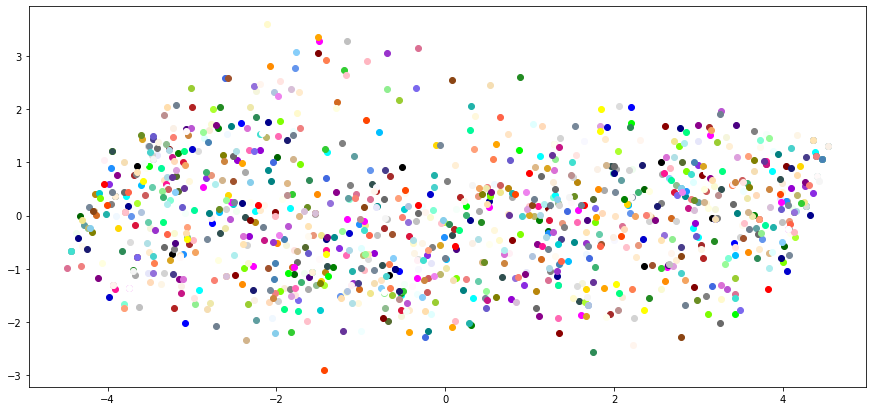

In [171]:
pca = PCA(n_components=2)
scaler = StandardScaler()
projected = pca.fit_transform(scaler.fit_transform(X_train))
print(pca.explained_variance_ratio_)
plt.figure(figsize=(15,7))
x = projected[:, 0].tolist()
y =  projected[:, 1].tolist()
colors = list(mcolors.CSS4_COLORS.keys())
for index,i in enumerate(list(set(df_borda_system.index))):
    filter_ = np.array([k == i for k in list(df_borda_system.index)])
    plt.scatter(np.array(x)[filter_],np.array(y)[filter_],c=colors[index])



u,m = [],[]
for i, txt in enumerate(zip(list(df_borda_system.index),list(df_borda_system['Utt']))):
    if ds == 'TAC_11.csv':
        if y[i] > 2:
            #plt.annotate(txt, (x[i], y[i]))
            u.append(txt[-1])
            m.append(txt[0])
    if ds == 'TAC_09.csv':
        if x[i] < -5.9 or x[i] > 5.9:
            u.append(txt[-1])
            m.append(txt[0])

        plt.annotate(txt, (x[i], y[i]))
print(set(u),sorted(set(m)))
plt.xlabel('component 1')
plt.ylabel('component 2')

# Analysis by utterance 

In [32]:
considered_df_utterance = pd.read_csv(os.path.join(data_path,ds)).set_index(['Utterance','System'])
assert considered_df_utterance.shape[0] % considered_df_utterance.loc['M0'].shape[0] == 0
nbs_utt = considered_df_utterance.shape[0] // considered_df_utterance.loc['M0'].shape[0] 
nbs_system = considered_df_utterance.loc['M0'].shape[0] 

In [33]:
nbs_system,nbs_utt

(100, 16)

In [34]:
dic_utterance = {}

for column in list(considered_df_utterance.columns):
    print(column)
    dic_utterance['borda_{}'.format(column)] = []
    for i in range(nbs_utt): 
        current_borda_count = np.argsort(np.argsort(
            considered_df_utterance.loc['M{}'.format(i)][column].values)).tolist()
        dic_utterance['borda_{}'.format(column)] += current_borda_count

H:coherence
H:consistency
H:fluency
H:relevance
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore


In [35]:
dic_utterance['System'] = sum([['M{}'.format(i) for i in range(nbs_system)]*nbs_utt],[]) # TODO : pas sur
dic_utterance['Utt'] = sum([['U{}'.format(i)]* nbs_utt  for i in range(nbs_system)],[])
df_borda_utterance = pd.DataFrame(dic_utterance).set_index('Utt')

In [36]:
human_metric = [ i for i in df_borda_utterance.columns if ('H:' in i and 'System' not in i)]
other_metric = [ i for i in df_borda_utterance.columns if ('H:' not in i and 'System' not in i)]
print("Human", human_metric)
print("Other", other_metric)

Human ['borda_H:coherence', 'borda_H:consistency', 'borda_H:fluency', 'borda_H:relevance']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']


In [37]:
X_train_utterance = df_borda_utterance.values[:,:-1]


[0.57323885 0.10212108]
('M46', 'U13')


Text(0, 0.5, 'component 2')

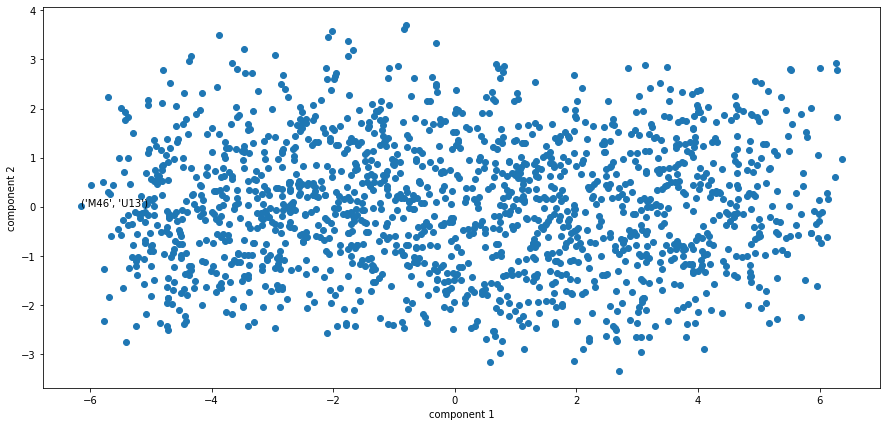

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)
scaler = StandardScaler()
projected = pca.fit_transform(scaler.fit_transform(X_train_utterance))
print(pca.explained_variance_ratio_)
plt.figure(figsize=(15,7))
x = projected[:, 0].tolist()
y =  projected[:, 1].tolist()
plt.scatter(x,y)

for i, txt in enumerate(zip(list(df_borda_system.index),list(df_borda_system['Utt']))):
    if x[i] < -6:
        print(txt)
        plt.annotate(txt, (x[i], y[i]))

plt.xlabel('component 1')
plt.ylabel('component 2')